In [ ]:
import time
import threading
import uuid
import random
import psutil
import math
from concurrent.futures import ThreadPoolExecutor
from queue import Queue
import collections
import logging
import subprocess
from config import SERVICE_TIME, INIT_THREAD_COUNT, MAX_CPU_USAGE, MIN_CPU_USAGE, MAX_TOTAL_WAITING_TASK_COUNT, MIN_TOTAL_WAITING_TASK_COUNT, WAIT_TIME_THRESHOLD, RUN_TIME_THRESHOLD, INCREASE_THREAD_COUNT_MAGNITUDE, DECREASE_THREAD_COUNT_MAGNITUDE

def get_commit_id():
    try:
        # 執行 git 指令，取得 commit id
        commit_id = subprocess.check_output(["git", "rev-parse", "HEAD"]).strip().decode("utf-8")[0:7]
        return commit_id
    except Exception as e:
        print(f"無法取得 commit id: {e}")
        return ""

# -----------------------
# Setup Logging
# -----------------------
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers: one for console and one for file output
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
commit_id = get_commit_id()
current_time = time.strftime('%Y%m%d_%H%M%S')
file_handler = logging.FileHandler(f'Output_Log\\{commit_id}_{current_time}.log', encoding="utf-8")
file_handler.setLevel(logging.INFO)

# Create a formatter and set it for both handlers
formatter = logging.Formatter('[%(asctime)s] %(message)s', datefmt='%H:%M:%S')
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# Add the handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

# -----------------------
# Global Variables and Data Structures
# -----------------------
thread_status = {}  # 用於儲存執行緒狀態
job_queue = Queue()  # 任務隊列
job_arrival_history = collections.deque(maxlen=100)  # 任務到達歷史，最多存儲100個數據點

last_job_generation_time = time.time()
total_jobs_in_hour = 0
hour_start_time = time.time()
current_optimal_threads =  INIT_THREAD_COUNT # 初始值

# -----------------------
# Function Definitions
# -----------------------

def calculate_optimal_thread_count():
    global current_optimal_threads
    current_time = time.time()

    if len(job_arrival_history) < 2:
        return current_optimal_threads

    timespan = min(1200, current_time - job_arrival_history[0][0])
    if timespan <= 0:
        return current_optimal_threads

    arrival_count = len(job_arrival_history)
    arrival_rate = arrival_count / timespan  # 每秒到達的任務數

    optimal_threads = math.ceil(arrival_rate * SERVICE_TIME)

    cpu_cores = psutil.cpu_count(logical=True)
    min_threads = max(3, cpu_cores // 2)
    max_threads = max(16, cpu_cores * 2)
    optimal_threads = max(min_threads, min(max_threads, optimal_threads))

    current_optimal_threads = int(0.7 * current_optimal_threads + 0.3 * optimal_threads)

    logger.info(f"Little's Law計算: 到達率={arrival_rate:.4f}/秒 (到達數/timespan = {arrival_count} / {timespan}), "
                f"服務時間={SERVICE_TIME}秒, 理論最佳執行緒數={optimal_threads}, "
                f"平滑後當前執行緒數={current_optimal_threads}")
    return current_optimal_threads

def get_dynamic_worker_count():
    optimal_threads = calculate_optimal_thread_count()
    cpu_usage = psutil.cpu_percent(interval=0.5)
    pending_count = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
    queue_size = job_queue.qsize()
    total_pending = pending_count + queue_size

    if cpu_usage > MAX_CPU_USAGE or total_pending < MAX_TOTAL_WAITING_TASK_COUNT:
        worker_count = max(3, int(optimal_threads * INCREASE_THREAD_COUNT_MAGNITUDE))
    elif cpu_usage < MIN_CPU_USAGE and total_pending > MIN_TOTAL_WAITING_TASK_COUNT:
        worker_count = min(20, int(optimal_threads * DECREASE_THREAD_COUNT_MAGNITUDE))
    else:
        worker_count = optimal_threads

    logger.info(f"執行緒池調整: CPU={cpu_usage:.1f}%, 等待任務={total_pending}, 執行緒數={worker_count}")
    return worker_count

def check_incomplete_jobs():
    current_time = time.time()
    rescheduled_count = 0
    global job_queue

    for job_id, status in list(thread_status.items()):
        if status["state"] == "PENDING":
            wait_time = current_time - status["queue_time"]
            if wait_time > WAIT_TIME_THRESHOLD:
                try:
                    job_queue.queue.remove(job_id)
                except Exception:
                    pass

                temp_queue = Queue()
                temp_queue.put(job_id)
                while not job_queue.empty():
                    temp_queue.put(job_queue.get())
                job_queue = temp_queue

                logger.info(f"重新排程長時間等待的執行緒 {job_id} (等待時間: {wait_time:.2f}秒)")
                rescheduled_count += 1

        elif status["state"] == "RUNNING":
            if "start_time" in status:
                run_time = current_time - status["start_time"]
                if run_time > RUN_TIME_THRESHOLD:
                    logger.info(f"警告: 執行緒 {job_id} 執行時間過長 ({run_time:.2f}秒)")

    if rescheduled_count > 0:
        logger.info(f"總共重新排程了 {rescheduled_count} 個長時間等待的執行緒")

def add_jobs():
    global last_job_generation_time, total_jobs_in_hour, hour_start_time, job_queue, thread_status
    while True:
        current_time = time.time()
        if current_time - hour_start_time > 3600:
            total_jobs_in_hour = 0
            hour_start_time = current_time
            logger.info("新的小時開始，重置任務計數")

        check_incomplete_jobs()

        optimal_threads = calculate_optimal_thread_count()
        pending_count = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
        queue_size = job_queue.qsize()
        running_count = sum(1 for v in thread_status.values() if v["state"] == "RUNNING")

        system_capacity = optimal_threads * 20
        current_load = (running_count * 20) + (pending_count + queue_size) * 20
        load_factor = current_load / (system_capacity + 0.1)

        remaining_hour_time = 3600 - (current_time - hour_start_time)
        remaining_intervals = max(1, remaining_hour_time / 300)
        remaining_jobs = 200 - total_jobs_in_hour
        target_jobs_per_interval = remaining_jobs / remaining_intervals

        if load_factor > 1.2:
            num_jobs = random.randint(1, 5)
        elif load_factor > 0.8:
            num_jobs = random.randint(3, 8)
        elif load_factor < 0.3:
            num_jobs = random.randint(15, 20)
        elif load_factor < 0.6:
            num_jobs = random.randint(10, 15)
        else:
            num_jobs = random.randint(5, 15)

        num_jobs = min(num_jobs, int(max(1, target_jobs_per_interval * 1.5)))
        num_jobs = max(1, min(20, num_jobs))

        for _ in range(num_jobs):
            job_id = str(uuid.uuid4())
            job_queue.put(job_id)
            thread_status[job_id] = {
                "state": "PENDING",
                "queue_time": current_time,
                "creation_time": time.strftime('%H:%M:%S')
            }
            job_arrival_history.append((current_time, job_id))

        total_jobs_in_hour += num_jobs

        logger.info(f"加入 {num_jobs} 個執行緒到佇列 (負載因子: {load_factor:.2f}, 本小時已生成: {total_jobs_in_hour})")
        last_job_generation_time = current_time
        time.sleep(300)

def process_thread(job_id):
    current_time = time.time()
    if job_id in thread_status:
        thread_status[job_id]["state"] = "RUNNING"
        thread_status[job_id]["start_time"] = current_time
        thread_status[job_id]["start_time_str"] = time.strftime('%H:%M:%S')
    else:
        thread_status[job_id] = {
            "state": "RUNNING",
            "start_time": current_time,
            "start_time_str": time.strftime('%H:%M:%S'),
            "queue_time": current_time,
            "creation_time": time.strftime('%H:%M:%S')
        }

    logger.info(f"執行執行緒 {job_id}")
    time.sleep(20)
    thread_status[job_id]["state"] = "COMPLETED"
    thread_status[job_id]["completion_time"] = time.time()
    thread_status[job_id]["completion_time_str"] = time.strftime('%H:%M:%S')

    execution_time = thread_status[job_id]["completion_time"] - thread_status[job_id]["start_time"]
    thread_status[job_id]["execution_time"] = execution_time

    wait_time = thread_status[job_id]["start_time"] - thread_status[job_id]["queue_time"]
    thread_status[job_id]["wait_time"] = wait_time

    logger.info(f"完成執行緒 {job_id} (執行時間: {execution_time:.2f}秒, 等待時間: {wait_time:.2f}秒)")

def monitor_threads():
    while True:
        time.sleep(60)
        current_time = time.time()
        completed = sum(1 for v in thread_status.values() if v["state"] == "COMPLETED")
        pending = sum(1 for v in thread_status.values() if v["state"] == "PENDING")
        running = sum(1 for v in thread_status.values() if v["state"] == "RUNNING")

        wait_times = [v.get("wait_time", 0) for v in thread_status.values() if v.get("wait_time") is not None]
        exec_times = [v.get("execution_time", 0) for v in thread_status.values() if v.get("execution_time") is not None]

        avg_wait = sum(wait_times) / len(wait_times) if wait_times else 0
        avg_exec = sum(exec_times) / len(exec_times) if exec_times else 0
        max_wait = max(wait_times) if wait_times else 0

        current_waiting_times = [current_time - status["queue_time"] for status in thread_status.values() if status["state"] == "PENDING"]
        current_max_wait = max(current_waiting_times) if current_waiting_times else 0

        logger.info(f"監控報告: 執行中 {running} / 等待中 {pending} / 完成 {completed}")
        logger.info(f"平均等待時間: {avg_wait:.2f}秒, 平均執行時間: {avg_exec:.2f}秒")
        logger.info(f"歷史最大等待時間: {max_wait:.2f}秒, 當前最大等待: {current_max_wait:.2f}秒")
        logger.info(f"佇列中任務數量: {job_queue.qsize()}")
        logger.info(f"本小時已產生任務: {total_jobs_in_hour}/200")

def detailed_status_report():
    while True:
        time.sleep(900)
        logger.info("=" * 50)
        logger.info("詳細狀態報告")
        logger.info("=" * 50)

        pending_jobs = [(job_id, status) for job_id, status in thread_status.items() if status["state"] == "PENDING"]
        if pending_jobs:
            logger.info("待處理任務:")
            for job_id, status in pending_jobs:
                wait_time = time.time() - status["queue_time"]
                logger.info(f"  - {job_id[:8]}: 等待中 ({wait_time:.2f}秒), 創建於 {status.get('creation_time', 'N/A')}")

        running_jobs = [(job_id, status) for job_id, status in thread_status.items() if status["state"] == "RUNNING"]
        if running_jobs:
            logger.info("執行中任務:")
            for job_id, status in running_jobs:
                runtime = time.time() - status["start_time"]
                logger.info(f"  - {job_id[:8]}: 執行中 ({runtime:.2f}秒), 開始於 {status.get('start_time_str', 'N/A')}")

        completed_jobs = [(job_id, status) for job_id, status in thread_status.items() if status["state"] == "COMPLETED"]
        if completed_jobs:
            recent_completed = sorted(
                completed_jobs,
                key=lambda x: x[1].get("completion_time", 0),
                reverse=True
            )[:10]
            logger.info("最近完成的任務:")
            for job_id, status in recent_completed:
                logger.info(f"  - {job_id[:8]}: 完成於 {status.get('completion_time_str', 'N/A')}, " +
                            f"執行時間: {status.get('execution_time', 0):.2f}秒, " +
                            f"等待時間: {status.get('wait_time', 0):.2f}秒")

        wait_times = [v.get("wait_time", 0) for v in thread_status.values() if v.get("wait_time") is not None]
        if wait_times:
            wait_times.sort()
            total = len(wait_times)
            logger.info("等待時間分析:")
            logger.info(f"  - 最小值: {min(wait_times):.2f}秒")
            logger.info(f"  - 25%分位: {wait_times[total//4]:.2f}秒")
            logger.info(f"  - 中位數: {wait_times[total//2]:.2f}秒")
            logger.info(f"  - 75%分位: {wait_times[3*total//4]:.2f}秒")
            logger.info(f"  - 最大值: {max(wait_times):.2f}秒")
            logger.info(f"  - 平均值: {sum(wait_times)/total:.2f}秒")
        logger.info("=" * 50)

def run_thread_pool():
    while True:
        max_workers = get_dynamic_worker_count()
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            pending_futures = []
            while not job_queue.empty():
                job_id = job_queue.get()
                if job_id in thread_status and thread_status[job_id]["state"] in ["RUNNING", "COMPLETED"]:
                    continue
                future = executor.submit(process_thread, job_id)
                pending_futures.append(future)
                if len(pending_futures) >= max_workers:
                    done, pending_futures = wait(pending_futures, return_when="FIRST_COMPLETED", timeout=0.5)
            for future in pending_futures:
                try:
                    future.result()
                except Exception as e:
                    logger.info(f"執行緒執行錯誤: {e}")
        time.sleep(1)

def wait(futures, return_when="ALL_COMPLETED", timeout=None):
    if return_when != "FIRST_COMPLETED":
        raise ValueError("僅支持FIRST_COMPLETED模式")
    start_time = time.time()
    done = []
    not_done = list(futures)
    while not_done:
        for future in list(not_done):
            if future.done():
                done.append(future)
                not_done.remove(future)
                return set(done), set(not_done)
        if timeout is not None and time.time() - start_time > timeout:
            break
        time.sleep(0.1)
    return list(done), list(not_done)

def main():
    threading.Thread(target=add_jobs, daemon=True).start()
    threading.Thread(target=run_thread_pool, daemon=True).start()
    threading.Thread(target=monitor_threads, daemon=True).start()
    threading.Thread(target=detailed_status_report, daemon=True).start()

    logger.info("系統已啟動")
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        logger.info("系統正在關閉...")

if __name__ == "__main__":
    main()


<string>:34: SyntaxWarning: invalid escape sequence '\{'
<>:34: SyntaxWarning: invalid escape sequence '\{'
<string>:34: SyntaxWarning: invalid escape sequence '\{'
<>:34: SyntaxWarning: invalid escape sequence '\{'
C:\Users\jgw09\AppData\Local\Temp\ipykernel_31492\1031004566.py:34: SyntaxWarning: invalid escape sequence '\{'
  file_handler = logging.FileHandler(f'Output_Log\{commit_id}_{current_time}.log', encoding="utf-8")
[20:42:41] 加入 18 個執行緒到佇列 (負載因子: 0.00, 本小時已生成: 18)
[20:42:41] Little's Law計算: 到達率=5444.7910/秒 (到達數/timespan = 18 / 0.0033059120178222656), 服務時間=20秒, 理論最佳執行緒數=16, 平滑後當前執行緒數=10
[20:42:41] 加入 18 個執行緒到佇列 (負載因子: 0.00, 本小時已生成: 18)
[20:42:41] Little's Law計算: 到達率=5444.7910/秒 (到達數/timespan = 18 / 0.0033059120178222656), 服務時間=20秒, 理論最佳執行緒數=16, 平滑後當前執行緒數=10
[20:42:41] 系統已啟動
[20:42:41] 系統已啟動
[20:42:42] 執行緒池調整: CPU=6.7%, 等待任務=36, 執行緒數=6
[20:42:42] 執行緒池調整: CPU=6.7%, 等待任務=36, 執行緒數=6
[20:42:42] 執行執行緒 fa2ebb2d-aa1c-4b71-abfe-8e071f5267e5
[20:42:42] 執行執行緒 fa2ebb2d-aa1c-4b71-abfe-8e07

分析結果

初始化優化系統模擬器 (模擬時長: 24小時)
開始執行模擬 (總時長: 24小時)
模擬進度: 5.0% (模擬時間: 01:12:00)
模擬進度: 10.0% (模擬時間: 02:24:00)
模擬進度: 15.0% (模擬時間: 03:36:00)
模擬進度: 20.0% (模擬時間: 04:48:00)
模擬進度: 25.0% (模擬時間: 06:00:00)
模擬進度: 30.0% (模擬時間: 07:12:00)
模擬進度: 35.0% (模擬時間: 08:24:00)
模擬進度: 40.0% (模擬時間: 09:36:00)
模擬進度: 45.0% (模擬時間: 10:48:00)
模擬進度: 50.0% (模擬時間: 12:00:00)
模擬進度: 55.0% (模擬時間: 13:12:00)
模擬進度: 60.0% (模擬時間: 14:24:00)
模擬進度: 65.0% (模擬時間: 15:36:00)
模擬進度: 70.0% (模擬時間: 16:48:00)
模擬進度: 75.0% (模擬時間: 18:00:00)
模擬進度: 80.0% (模擬時間: 19:12:00)
模擬進度: 85.0% (模擬時間: 20:24:00)
模擬進度: 90.0% (模擬時間: 21:36:00)
模擬進度: 95.0% (模擬時間: 22:48:00)
模擬完成 (實際執行時間: 62.03秒)

 優化系統模擬結果摘要

效能指標:
平均等待時間: 46.04秒
最大等待時間: 126.00秒
中位數等待時間: 42.00秒
95%分位等待時間: 105.00秒
平均響應時間: 66.04秒
每小時任務處理量: 199.96個/小時
平均佇列長度: 2.56
最大佇列長度: 17
執行緒利用率: 34.20%

任務統計:
總任務數: 4799
完成任務數: 4799
任務完成率: 100.00%

等待時間分布:
0-30秒: 38.76%
30-60秒: 18.73%
60-120秒: 40.68%
120-300秒: 1.83%
300+秒: 0.00%



C:\Users\jgw09\AppData\Local\Temp\ipykernel_31492\43410515.py:303: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
C:\Users\jgw09\AppData\Local\Temp\ipykernel_31492\43410515.py:303: UserWarning: Glyph 25836 (\N{CJK UNIFIED IDEOGRAPH-64EC}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
C:\Users\jgw09\AppData\Local\Temp\ipykernel_31492\43410515.py:303: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
C:\Users\jgw09\AppData\Local\Temp\ipykernel_31492\43410515.py:303: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題
C:\Users\jgw09\AppData\Local\Temp\ipykernel_31492\43410515.py:303: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  plt.tight_layout(rect=

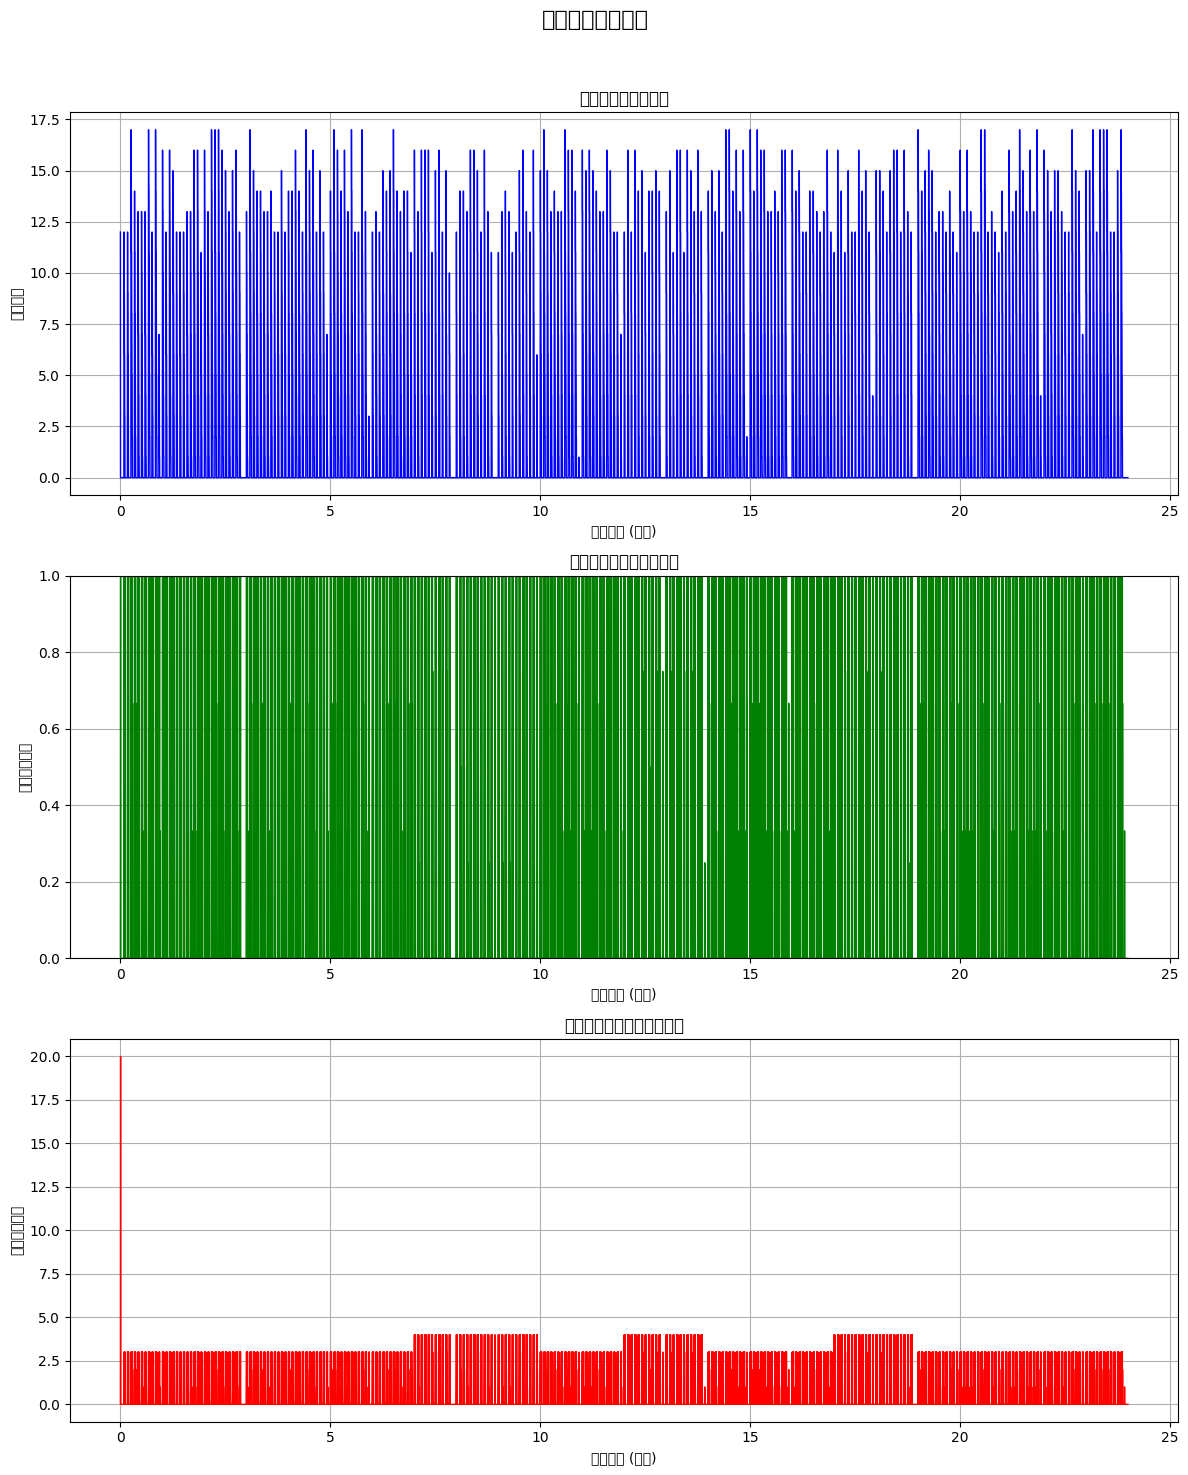

C:\Users\jgw09\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jgw09\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21209 (\N{CJK UNIFIED IDEOGRAPH-52D9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jgw09\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jgw09\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24453 (\N{CJK UNIFIED IDEOGRAPH-5F85}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jgw09\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 209

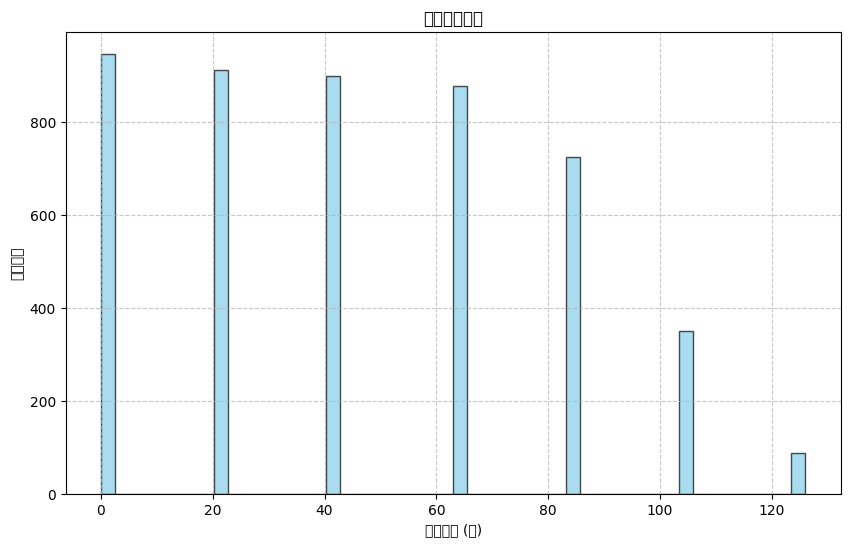

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# 在此處添加模擬器程式碼
# 這部分應該在原始系統程式碼之後

import time
import statistics
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import display
from config import SERVICE_TIME


class SystemSimulator:
    def __init__(self, is_optimized=True, simulation_hours=24, random_seed=42):
        self.is_optimized = is_optimized
        self.simulation_hours = simulation_hours
        self.current_time = 0  # 模擬時間（秒）
        self.thread_status = {}
        self.job_queue = []
        self.completed_jobs = []
        self.thread_count = 8  # 初始/固定執行緒數
        self.total_jobs_in_hour = 0
        self.hour_start_time = 0
        self.job_arrival_history = []

        # 設置隨機種子確保結果可重複
        random.seed(random_seed)

        # 統計數據
        self.wait_times = []
        self.response_times = []
        self.thread_utilization = []
        self.queue_lengths = []
        self.active_threads = []
        self.time_records = []

        # 模擬不同負載的時段
        self.peak_hours = [7, 8, 9, 12, 13, 17, 18]  # 尖峰時段

        print(f"初始化{'優化' if is_optimized else '基本'}系統模擬器 (模擬時長: {simulation_hours}小時)")

    def get_thread_count(self):
        """計算當前應使用的執行緒數量"""
        if not self.is_optimized:
            return self.thread_count

        # 簡化的Little's Law實現
        # 計算最近一小時內的到達率
        recent_arrivals = [job for job, t in self.job_arrival_history
                            if t > self.current_time - 3600]

        if not recent_arrivals or self.current_time == 0:
            return self.thread_count

        arrival_rate = len(recent_arrivals) / max(1, min(3600, self.current_time))

        # Little's Law: L = λW
        optimal_threads = max(3, min(20, int(arrival_rate * SERVICE_TIME)))

        # 考慮當前時段是否為尖峰時段
        current_hour = (self.current_time // 3600) % 24
        is_peak_hour = current_hour in self.peak_hours

        # 在尖峰時段增加執行緒數
        if is_peak_hour and self.is_optimized:
            optimal_threads = min(20, int(optimal_threads * 1.5))

        return optimal_threads

    def generate_jobs(self):
        """產生新任務"""
        # 檢查是否進入新的小時
        current_hour = self.current_time // 3600
        if current_hour > self.hour_start_time // 3600:
            self.total_jobs_in_hour = 0
            self.hour_start_time = current_hour * 3600

        # 確定產生任務數量
        if self.is_optimized:
            # 考慮當前佇列大小和系統負載
            queue_size = len(self.job_queue)
            running_jobs = sum(1 for job in self.thread_status.values()
                                if job["state"] == "RUNNING")

            # 計算系統負載因子
            current_thread_count = self.get_thread_count()
            load_factor = (running_jobs + queue_size) / max(1, current_thread_count)

            # 根據負載調整產生數量
            if load_factor > 1.2:  # 負載很高
                num_jobs = random.randint(1, 5)
            elif load_factor < 0.3:  # 負載很低
                num_jobs = random.randint(15, 20)
            else:  # 負載適中
                num_jobs = random.randint(5, 15)
        else:
            # 簡單版本：固定隨機數 (1-20)
            num_jobs = random.randint(1, 20)

        # 確保不超過每小時限制
        remaining_jobs = 200 - self.total_jobs_in_hour
        num_jobs = min(num_jobs, remaining_jobs)

        # 產生任務
        for _ in range(num_jobs):
            job_id = f"job_{len(self.thread_status)}"
            self.job_queue.append(job_id)
            self.thread_status[job_id] = {
                "state": "PENDING",
                "queue_time": self.current_time,
                "creation_time": self.current_time
            }
            self.job_arrival_history.append((job_id, self.current_time))

        self.total_jobs_in_hour += num_jobs
        return num_jobs

    def check_unfinished_tasks(self):
        """檢查未完成的任務並重新排程 (符合條件3)"""
        if self.current_time % 300 != 0:  # 每5分鐘檢查一次
            return

        rescheduled_count = 0

        for job_id in list(self.job_queue):
            if job_id in self.thread_status and self.thread_status[job_id]["state"] == "PENDING":
                # 計算等待時間
                wait_time = self.current_time - self.thread_status[job_id]["queue_time"]

                # 如果使用優化系統，長時間等待的任務會被提高優先級
                if self.is_optimized and wait_time > 300:  # 等待超過5分鐘
                    self.job_queue.remove(job_id)
                    self.job_queue.insert(0, job_id)  # 放到佇列前端
                    rescheduled_count += 1

        if rescheduled_count > 0 and self.is_optimized:
            print(f"[{self.format_time(self.current_time)}] 重新排程了 {rescheduled_count} 個長時間等待的任務")

    def process_jobs(self):
        """處理佇列中的任務"""
        current_thread_count = self.get_thread_count()
        running_jobs = sum(1 for job in self.thread_status.values()
                            if job["state"] == "RUNNING")

        # 記錄執行緒利用率
        self.thread_utilization.append(running_jobs / max(1, current_thread_count))
        self.active_threads.append(running_jobs)

        # 處理已完成的任務
        for job_id, status in list(self.thread_status.items()):
            if status["state"] == "RUNNING":
                if self.current_time >= status["start_time"] + 20:  # 任務完成 (20秒)
                    status["state"] = "COMPLETED"
                    status["completion_time"] = self.current_time

                    # 計算等待和響應時間
                    wait_time = status["start_time"] - status["queue_time"]
                    response_time = status["completion_time"] - status["queue_time"]

                    status["wait_time"] = wait_time
                    status["response_time"] = response_time

                    self.wait_times.append(wait_time)
                    self.response_times.append(response_time)
                    self.completed_jobs.append(job_id)

        # 檢查是否需要重新排程長等待任務
        self.check_unfinished_tasks()

        # 啟動新任務
        available_threads = current_thread_count - running_jobs
        for _ in range(min(available_threads, len(self.job_queue))):
            if not self.job_queue:
                break

            job_id = self.job_queue.pop(0)
            if job_id in self.thread_status and self.thread_status[job_id]["state"] == "PENDING":
                self.thread_status[job_id]["state"] = "RUNNING"
                self.thread_status[job_id]["start_time"] = self.current_time

    def format_time(self, seconds):
        """將秒數格式化為時:分:秒"""
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        secs = seconds % 60
        return f"{hours:02d}:{minutes:02d}:{secs:02d}"

    def run_simulation(self):
        """執行模擬"""
        total_simulation_time = self.simulation_hours * 3600  # 轉換為秒

        print(f"開始執行模擬 (總時長: {self.simulation_hours}小時)")
        simulation_start = time.time()  # 記錄實際執行時間

        progress_interval = total_simulation_time // 20  # 顯示20次進度
        next_progress = progress_interval

        while self.current_time < total_simulation_time:
            # 每5分鐘產生新任務
            if self.current_time % 300 == 0:
                self.generate_jobs()

            # 處理任務
            self.process_jobs()

            # 記錄佇列長度
            self.queue_lengths.append(len(self.job_queue))
            self.time_records.append(self.current_time)

            # 顯示進度
            if self.current_time >= next_progress:
                percent_done = (self.current_time / total_simulation_time) * 100
                print(f"模擬進度: {percent_done:.1f}% (模擬時間: {self.format_time(self.current_time)})")
                next_progress += progress_interval

            # 時間前進
            self.current_time += 1

        simulation_time = time.time() - simulation_start
        print(f"模擬完成 (實際執行時間: {simulation_time:.2f}秒)")

        # 返回模擬結果
        return self.get_statistics()

    def get_statistics(self):
        """取得模擬統計數據"""
        if not self.wait_times:
            return {
                "avg_wait_time": 0,
                "max_wait_time": 0,
                "avg_response_time": 0,
                "throughput": 0,
                "avg_queue_length": 0,
                "max_queue_length": 0,
                "thread_utilization": 0
            }

        # 等待時間分佈分析
        wait_times_np = np.array(self.wait_times)
        wait_time_dist = {
            "0-30秒": sum(1 for t in self.wait_times if t <= 30) / len(self.wait_times) * 100,
            "30-60秒": sum(1 for t in self.wait_times if 30 < t <= 60) / len(self.wait_times) * 100,
            "60-120秒": sum(1 for t in self.wait_times if 60 < t <= 120) / len(self.wait_times) * 100,
            "120-300秒": sum(1 for t in self.wait_times if 120 < t <= 300) / len(self.wait_times) * 100,
            "300+秒": sum(1 for t in self.wait_times if t > 300) / len(self.wait_times) * 100
        }

        stats = {
            "avg_wait_time": statistics.mean(self.wait_times),
            "max_wait_time": max(self.wait_times),
            "median_wait_time": statistics.median(self.wait_times),
            "p95_wait_time": np.percentile(self.wait_times, 95),
            "avg_response_time": statistics.mean(self.response_times),
            "throughput": len(self.completed_jobs) / (self.simulation_hours * 3600) * 3600,  # 每小時
            "avg_queue_length": statistics.mean(self.queue_lengths),
            "max_queue_length": max(self.queue_lengths),
            "thread_utilization": statistics.mean(self.thread_utilization),
            "wait_time_distribution": wait_time_dist,
            "completed_jobs": len(self.completed_jobs),
            "total_jobs": len(self.thread_status),
            "completion_rate": len(self.completed_jobs) / len(self.thread_status) * 100 if len(self.thread_status) > 0 else 0
        }

        return stats

    def plot_results(self):
        """繪製模擬結果圖表"""
        if not self.time_records:
            print("沒有模擬數據可用於繪圖")
            return None

        # 轉換時間記錄為小時
        hours = [t/3600 for t in self.time_records]

        # 建立子圖
        fig, axs = plt.subplots(3, 1, figsize=(12, 15))
        fig.suptitle(f"{'優化' if self.is_optimized else '基本'}系統模擬結果", fontsize=16)

        # 佇列長度隨時間變化
        axs[0].plot(hours, self.queue_lengths, 'b-', linewidth=1)
        axs[0].set_title('佇列長度隨時間變化')
        axs[0].set_xlabel('模擬時間 (小時)')
        axs[0].set_ylabel('佇列長度')
        axs[0].grid(True)

        # 執行緒利用率隨時間變化
        axs[1].plot(hours, self.thread_utilization, 'g-', linewidth=1)
        axs[1].set_title('執行緒利用率隨時間變化')
        axs[1].set_xlabel('模擬時間 (小時)')
        axs[1].set_ylabel('執行緒利用率')
        axs[1].set_ylim(0, 1.0)
        axs[1].grid(True)

        # 活躍執行緒數量隨時間變化
        axs[2].plot(hours, self.active_threads, 'r-', linewidth=1)
        axs[2].set_title('活躍執行緒數量隨時間變化')
        axs[2].set_xlabel('模擬時間 (小時)')
        axs[2].set_ylabel('活躍執行緒數')
        axs[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # 調整布局以適應標題

        # 等待時間分布直方圖
        plt.figure(figsize=(10, 6))
        plt.hist(self.wait_times, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('等待時間分布')
        plt.xlabel('等待時間 (秒)')
        plt.ylabel('任務數量')
        plt.grid(True, linestyle='--', alpha=0.7)

        return fig

    def display_summary(self):
        """顯示模擬結果摘要"""
        stats = self.get_statistics()

        print("\n" + "="*50)
        print(f" {'優化' if self.is_optimized else '基本'}系統模擬結果摘要")
        print("="*50)

        print(f"\n效能指標:")
        print(f"平均等待時間: {stats['avg_wait_time']:.2f}秒")
        print(f"最大等待時間: {stats['max_wait_time']:.2f}秒")
        print(f"中位數等待時間: {stats['median_wait_time']:.2f}秒")
        print(f"95%分位等待時間: {stats['p95_wait_time']:.2f}秒")
        print(f"平均響應時間: {stats['avg_response_time']:.2f}秒")
        print(f"每小時任務處理量: {stats['throughput']:.2f}個/小時")
        print(f"平均佇列長度: {stats['avg_queue_length']:.2f}")
        print(f"最大佇列長度: {stats['max_queue_length']}")
        print(f"執行緒利用率: {stats['thread_utilization']*100:.2f}%")

        print(f"\n任務統計:")
        print(f"總任務數: {stats['total_jobs']}")
        print(f"完成任務數: {stats['completed_jobs']}")
        print(f"任務完成率: {stats['completion_rate']:.2f}%")

        print(f"\n等待時間分布:")
        for range_name, percentage in stats['wait_time_distribution'].items():
            print(f"{range_name}: {percentage:.2f}%")

        print("\n" + "="*50)

        return stats

# 創建並執行模擬器
def run_simulation(is_optimized=True, hours=24, seed=42):
    simulator = SystemSimulator(is_optimized=is_optimized, simulation_hours=hours, random_seed=seed)
    results = simulator.run_simulation()
    simulator.display_summary()

    # 繪製圖表
    simulator.plot_results()
    plt.show()

    return simulator, results

# 在優化系統筆記本執行
simulator, results = run_simulation(is_optimized=True)

# 保存結果供後續比較
import pickle
with open('optimized_system_results.pkl', 'wb') as f:
    pickle.dump({
        'stats': results,
        'wait_times': simulator.wait_times,
        'queue_lengths': simulator.queue_lengths,
        'thread_utilization': simulator.thread_utilization,
        'active_threads': simulator.active_threads,
        'time_records': simulator.time_records
    }, f)

# 下載結果檔案 (在 Colab 上才需要)
# from google.colab import files
# files.download('optimized_system_results.pkl')

# print("\n模擬器執行完成，結果已保存為 'optimized_system_results.pkl'")
# print("請在基本系統筆記本中也執行類似的模擬，將 is_optimized 設為 False")
# print("然後使用第三個筆記本進行比較分析")